Figures for

# Predicting competition results from growth curves

by Yoav Ram, Eynat Deluss-Gur, Uri Obolski, Maayan Bibi, Judith Berman, and Lilach Hadany.

*A manuscript in preparation.*

#### Preprint: 

Ram et al. (2015) Predicting competition results from growth curves. bioRxiv doi: [10.1101/022640](http://biorxiv.org/content/early/2015/07/23/022640).

#### Notebook
This Jupyter notebook is an electronic supplementry material of the article.

The notebook **will be available** available at https://github.com/yoavram/curveball_ms/blob/master/supp.ipynb.

In [1]:
from imp import reload
import pkg_resources
import os
%matplotlib inline
import matplotlib.pyplot as plt
plt.warnings.simplefilter('ignore', FutureWarning)
plt.warnings.simplefilter('ignore', DeprecationWarning)
import numpy as np
import pandas as pd
from scipy.stats import linregress
from scipy.integrate import odeint
import seaborn as sns
sns.set(style='white', context='paper', font_scale=2, palette='Set1')
red, blue, green = sns.color_palette('Set1', 3)
width, height = plt.rcParams['figure.figsize']
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['lines.markersize'] = 7.5
panel_label_size = plt.rcParams[ 'axes.titlesize']*1.3
fit_ls = '-' # model fit linestyle
pred_ls = '--' # model prediction linestyle

In [2]:
import curveball
import curveball.scripts.cli
print('Curveball, ', curveball.__version__)
folder = os.path.join('D:\\', 'Dropbox', 'ex silico')
print('Working folder:', folder)

Curveball,  0.2.3+8.g864a3f6
Working folder: D:\Dropbox\ex silico


In [3]:
def fig_xlabel(fig, label):
    fig.text(0.5, 0, label, horizontalalignment='center', verticalalignment='bottom')

In [4]:
import collections
datasets = collections.OrderedDict()
datasets['2015-11-18'] = {
    'plate_file': os.path.join(folder, 'tecan', 'plate_181115.csv'),
    'OD_file': os.path.join(folder, 'tecan', 'Yoav_181115.xlsx'),
    'max_time': 12,
    'bad_wells': ['B2','E1','C4','A2'] + # G outliers
                 ['H9','C11','A10','C12','A11','A9','C9','H11'] + # R outliers
                 ['E5','E8','H6','H8','H7','H5'], # RG outliers
    'flow_mean_file': os.path.join(folder, 'flow', 'mean_df_2015-11-18.csv'),
    'flow_std_file': os.path.join(folder, 'flow', 'std_df_2015-11-18.csv'),
    'lag': True
}
datasets['2015-12-14'] = {
    'plate_file': os.path.join(folder, 'tecan', 'plate_141215.csv'),
    'OD_file': os.path.join(folder, 'tecan', 'Yoav_141215.xlsx'),
    'max_time': 7,
    'bad_wells': ['{}{}'.format(c, i) for c in 'ABCDEFGH' for i in range(4, 8)] + # used for flow samples
                 ['B10','B11','C10','A11','E11','A12'] + # red outliers
                 ['D8','H8'], # RG outliers
    'flow_mean_file': os.path.join(folder, 'flow', 'mean_df_2015-12-14.csv'),
    'flow_std_file': os.path.join(folder, 'flow', 'std_df_2015-12-14.csv'),
    'lag': False
}
datasets['2016-01-06'] = {
    'plate_file': os.path.join(folder, 'tecan', 'plate_060116.csv'),
    'OD_file': os.path.join(folder, 'tecan', 'Yoav_060116.xlsx'),
    'max_time': 10,
    'bad_wells': #['{}{}'.format(c, i) for c in 'BCDEG' for i in range(4, 8)] + # used for flow samples                 
                 ['A4','F4','G3'] + # G outliers
                 ['E12','A10','D10'] + # R outliers
                 ['H5','H6','G8'] , # RG outliers
    'flow_mean_file': os.path.join(folder, 'flow', 'mean_df_2016-01-06.csv'),
    'flow_std_file': os.path.join(folder, 'flow', 'std_df_2016-01-06.csv'),
    'lag': True
}
# datasets['2015-12-23'] = {
#     'plate_file': os.path.join(folder, 'tecan', 'plate_231215.csv'),
#     'OD_file': os.path.join(folder, 'tecan', 'Yoav_231215.xlsx'),
#     'max_time': 8,
#     'bad_wells': ['{}{}'.format(c, i) for c in 'ABCDEFGH' for i in range(4, 8)] + # used for flow samples
#                  ['A1'] + # G outliers
#                  ['D11','A11','A12','D10','H10','C10'] + # R outliers
#                  ['A8','A9', 'B8', 'B9', 'C9', 'D8', 'H8'], # RG outliers
#     'flow_mean_file': os.path.join(folder, 'flow', 'mean_df_2015-12-23.csv'),
#     'flow_std_file': os.path.join(folder, 'flow', 'std_df_2015-12-23.csv'),
#     'lag': False
# }

In [5]:
for ds in datasets.values():
    ds['plate'] = pd.read_csv(ds['plate_file'])
    ds['df'] = curveball.ioutils.read_tecan_xlsx(ds['OD_file'], plate=ds['plate'], max_time=ds['max_time'])
    ds['df'] = ds['df'][~ds['df'].Well.isin(ds['bad_wells'])]
    ds['dfG'] = ds['df'][ds['df'].Strain.str.contains('GFP')]
    ds['dfR'] = ds['df'][ds['df'].Strain.str.contains('RFP')]
    ds['dfRG'] = ds['df'][ds['df'].Strain=='mixed']
    ds['RG0_mean'] = ds['dfRG'][(ds['dfRG'].Time==ds['dfRG'].Time.min())].OD.mean()
    ds['RG_time'] = ds['dfRG'].Time.unique()
    ds['RG_mean'] = ds['dfRG'].groupby(by='Time').OD.mean()
    ds['RG_std'] = ds['dfRG'].groupby(by='Time').OD.std(ddof=1)

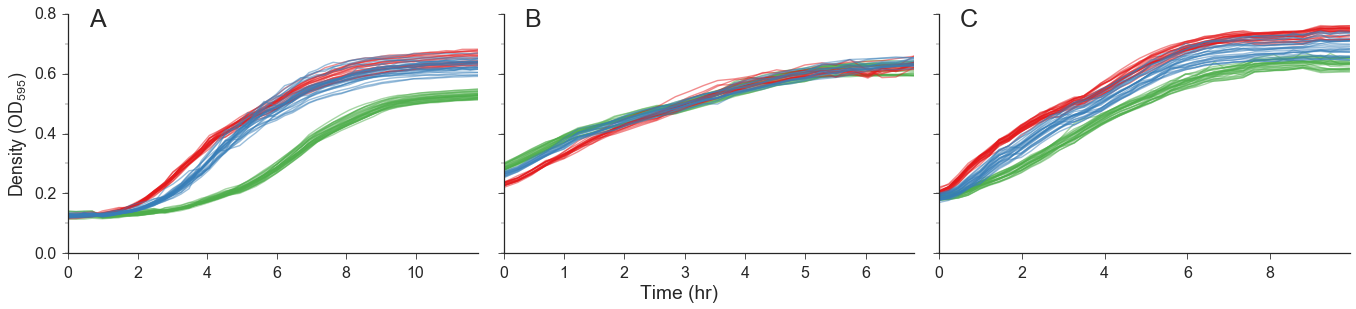

In [6]:
cols = len(datasets)
fig, ax = plt.subplots(1, cols, sharex=False, sharey=True, figsize=(width * cols, height))
for i,(name, ds) in enumerate(datasets.items()):
    for well in ds['dfG'].Well.unique():
        ds['dfG'][ds['dfG'].Well==well].plot(x='Time', y='OD', color=green, alpha=0.5, ax=ax[i])
    for well in ds['dfR'].Well.unique():
        ds['dfR'][ds['dfR'].Well==well].plot(x='Time', y='OD', color=red, alpha=0.5, ax=ax[i])
    for well in ds['dfRG'].Well.unique():
        ds['dfRG'][ds['dfRG'].Well==well].plot(x='Time', y='OD', color=blue, alpha=0.5, ax=ax[i])
    ax[i].set(title='', xlabel='')
    if i == 0:
        ax[i].set(
            ylabel=r'Density ($OD_{595}$)',
            yticks=[0,0.2,0.4,0.6,0.8],
            ylim=(0, 0.8)
        )
    else:
        ax[i].set(ylabel='')
    lg = ax[i].legend()
    if lg:
        lg.set_visible(False)
    
fig_xlabel(fig, 'Time (hr)')
for i,axes in enumerate(ax.flatten()):
    axes.annotate('ABCD'[i], (0.05, 0.95), xycoords='axes fraction', fontsize=panel_label_size)

fig.tight_layout()
sns.despine()
fig.savefig('Fig-wells.png')
fig.savefig('Fig-wells.pdf', dpi=300)

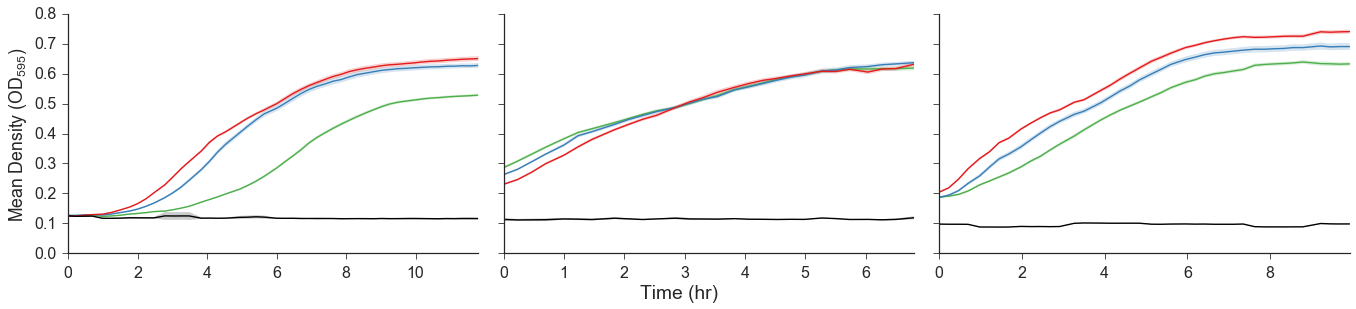

In [7]:
cols = len(datasets)
fig, ax = plt.subplots(1, cols, sharex=False, sharey=True, figsize=(width * cols, height))
for i,(name, ds) in enumerate(datasets.items()):
    curveball.plots.tsplot(ds['df'], ax=ax[i])
    ax[i].set(title='', xlabel='')
    if i == 0:
        ax[i].set(ylabel=r'Mean Density ($OD_{595}$)')     
    else:
        ax[i].set(ylabel='')
    ax[i].legend().set_visible(False)
fig_xlabel(fig, 'Time (hr)')
fig.tight_layout()
fig.savefig('Fig-tsplot.png')
fig.savefig('Fig-tsplot.pdf', dpi=300)

In [8]:
for ds in datasets.values():
    param_fix = {'y0', 'K'}
    param_guess = None
    if not ds['lag']:
        param_fix.add('q0')
        param_fix.add('v')
        param_guess = {'q0': np.inf, 'v': np.inf}
    models_G = curveball.models.fit_model(ds['dfG'], param_fix=param_fix, param_guess=param_guess, PRINT=False, PLOT=False)
    ds['model_G'] = models_G[0]
    models_R = curveball.models.fit_model(ds['dfR'], param_fix=param_fix, param_guess=param_guess, PRINT=False, PLOT=False)
    ds['model_R'] = models_R[0]
    models_RG = curveball.models.fit_model(ds['dfRG'], param_fix=param_fix, param_guess=param_guess, PRINT=False, PLOT=False)
    ds['model_RG'] = models_RG[0]

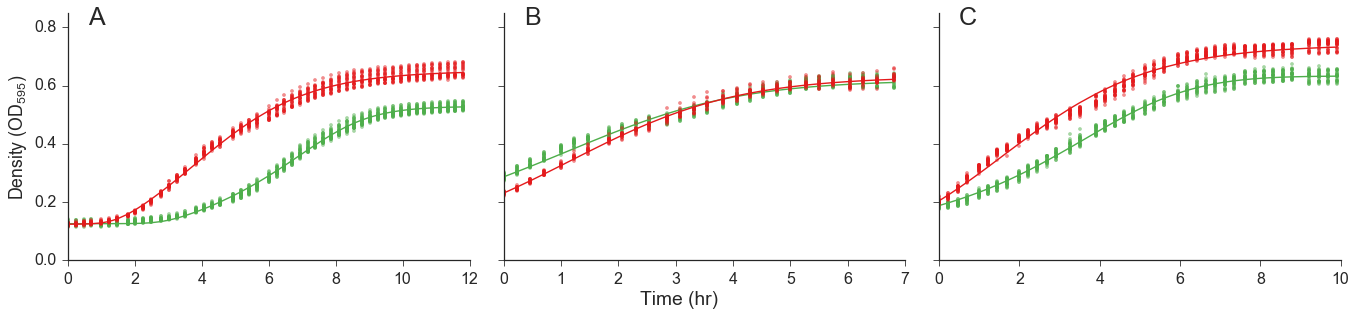

In [9]:
cols = len(datasets)
fig, ax = plt.subplots(1, cols, sharex=False, sharey=True, figsize=(width * cols, height))
for i,(name, ds) in enumerate(datasets.items()):
    ds['model_G'].plot_fit(ax=ax[i], fit_kws={'color':green, 'ls':fit_ls}, data_kws={'color':green,'alpha':0.5, 'marker':'.'}, init_kws={'ls':''})
    ds['model_R'].plot_fit(ax=ax[i], fit_kws={'color':red, 'ls':fit_ls}, data_kws={'color':red, 'alpha':0.5, 'marker':'.'}, init_kws={'ls':''})
    #ds['model_RG'].plot_fit(ax=ax[i], fit_kws={'color':blue}, data_kws={'color':blue,'alpha':0.5, 'marker':'.'}, init_kws={'ls':''})
    
    ax[i].set(
        title='', 
        xlabel='',
        ylim=(0,0.85),
        yticks=[0,0.2,0.4,0.6,0.8],
    )
    if i == 0:
        ax[i].set(ylabel=r'Density ($OD_{595}$)')
    else:
        ax[i].set(ylabel='')
    ax[i].legend().set_visible(False)

fig_xlabel(fig, 'Time (hr)')
for i,axes in enumerate(ax.flatten()):
    axes.annotate('ABCD'[i], (0.05, 0.95), xycoords='axes fraction', fontsize=panel_label_size)

fig.tight_layout()
sns.despine()
fig.savefig('Fig-model_fitting.png')
fig.savefig('Fig-model_fitting.pdf', dpi=300)

In [10]:
for name, ds in datasets.items():
    print(name)
    print('Green')
    print(ds['model_G'].fit_report())
    print('Red')
    print(ds['model_R'].fit_report())

2015-11-18
Green
[[Model]]
    Model(BaranyiRoberts)
[[Fit Statistics]]
    # function evals   = 76
    # data points      = 1372
    # variables        = 4
    chi-square         = 0.147
    reduced chi-square = 0.000
[[Variables]]
    y0:   0.1256464 (fixed)
    K:    0.5283857 (fixed)
    r:    0.26488892 +/- 0        (0.00%) (init= 0.3962055)
    nu:   4.41737938 +/- 0        (0.00%) (init= 1)
    q0:   0.00010000 +/- 0        (0.00%) (init= 0.0001000048)
    v:    3.31626960 +/- 0        (0.00%) (init= 4.379141)
[[Correlations]] (unreported correlations are <  0.100)

Red
[[Model]]
    Model(LogisticLag2)
[[Fit Statistics]]
    # function evals   = 62
    # data points      = 1078
    # variables        = 3
    chi-square         = 0.229
    reduced chi-square = 0.000
[[Variables]]
    y0:   0.1238273 (fixed)
    K:    0.6504273 (fixed)
    r:    0.58750625 +/- 0.003327 (0.57%) (init= 0.4687233)
    q0:   0.00816976 +/- 0.006545 (80.12%) (init= 0.0006795697)
    v:    3.73828335 +

In [11]:
for name, ds in datasets.items():
    print(name)
    print('Green')
    print(curveball.models.find_max_growth(ds['model_G'])[-1])
    print(curveball.models.find_lag(ds['model_G']))
    print('Red')
    print(curveball.models.find_max_growth(ds['model_R'])[-1])
    print(curveball.models.find_lag(ds['model_R']))

2015-11-18
Green
0.260430017118
3.79576245866
Red
0.376400955947
1.5779722106
2015-12-14
Green
0.255995292349
0.00422750662788
Red
0.370471107822
0.0156438808485
2016-01-06
Green
0.227804036003
0.705228754531
Red
0.408413734931
0.0584615930238


## Exponential model

In [12]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def smooth(x, y, **kwargs):
    if 'return_sorted' not in kwargs:
        kwargs['return_sorted'] = False
    if 'missing' not in kwargs:
        kwargs['missing'] = 'raise'
    yhat = lowess(y, x, **kwargs)
    return yhat

In [13]:
def expnential_model(mGreen, mRed, frac_green=0.3, frac_red=0.3, di=2, 
                     colors=sns.color_palette('Set1', 3)[::2], ax=None, PLOT=False):
    G = np.unique(mGreen.best_fit)
    tG = np.unique(mGreen.userkws['t'])
    dt = (tG.max() - tG.min())/G.size
    dGdt = np.gradient(G, dt)

    R = np.unique(mRed.best_fit)
    tR = np.unique(mRed.userkws['t'])
    dt = (tR.max() - tR.min())/R.size
    dRdt = np.gradient(R, dt)

    dGdt_smooth = smooth(tG, dGdt, frac=frac_green)
    dRdt_smooth = smooth(tR, dRdt, frac=frac_red)
    
    
    imaxG = dGdt_smooth.argmax()
    slopeG, interceptG, _, _, _ = linregress(tG[imaxG-di:imaxG+di], np.log(G[imaxG-di:imaxG+di]))
    imaxR = dRdt_smooth.argmax()
    slopeR, interceptR, _, _, _ = linregress(tR[imaxR-di:imaxR+di], np.log(R[imaxR-di:imaxR+di]))

    if PLOT:
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure
        ax.plot(tG, G, color=colors[1])
        ax.plot(tG, np.exp(slopeG * tG + interceptG), '--', color=colors[1])
        ax.plot(tR, R, color=colors[0])
        ax.plot(tR, np.exp(slopeR * tR + interceptR), '--', color=colors[0])

        ax.set(ylim=(0.9*min(G.min(), R.min()), 1.1*max(G.max(), R.max())), xlabel='Time (hour)', ylabel='log OD', yscale='log')        
        fig.tight_layout()
        sns.despine()
        return slopeG, interceptG, slopeR, interceptR, fig, ax 
    return slopeG, interceptG, slopeR, interceptR

2015-11-18 r_G=0.23, r_R=0.302
2015-12-14 r_G=0.229, r_R=0.318
2016-01-06 r_G=0.19, r_R=0.212


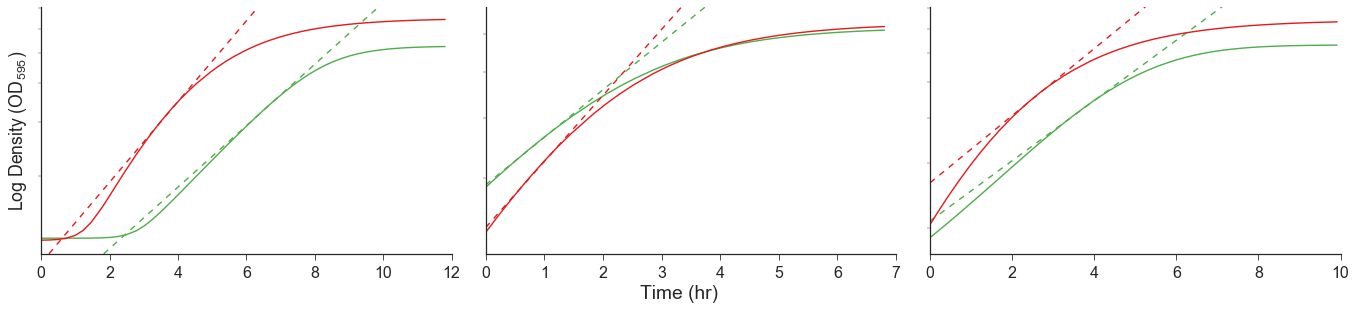

In [14]:
cols = len(datasets)
fig, ax = plt.subplots(1, cols, sharex=False, sharey=False, figsize=(width * cols, height))
for i,(name, ds) in enumerate(datasets.items()):
    ds['slopeG'], ds['interceptG'], ds['slopeR'], ds['interceptR'], _, _  = expnential_model(ds['model_G'], ds['model_R'], ax=ax[i], PLOT=True)    
    print(name, 'r_G={:.3g}, r_R={:.3g}'.format(ds['slopeG'], ds['slopeR']))
    ax[i].set(title='', xlabel='')
    if i == 0:
        ax[i].set(ylabel=r'Log Density ($OD_{595}$)')
    else:
        ax[i].set(ylabel='')
fig_xlabel(fig, 'Time (hr)')
fig.tight_layout()
sns.despine()
fig.savefig('Fig-exponential_model.png')
fig.savefig('Fig-exponential_model.pdf', dpi=300)

## Competition experiment

In [15]:
for ds in datasets.values():
    ds['flow_mean_df'] = pd.read_csv(ds['flow_mean_file'])
    ds['flow_std_df'] = pd.read_csv(ds['flow_std_file'])

In [25]:
reload(curveball.competitions)
ode = curveball.competitions.baranyi_roberts_yr2

for name, ds in datasets.items():
    print(name, end=" ")
    K = ds['model_G'].best_values['K'], ds['model_R'].best_values['K']
    r = ds['model_G'].best_values['r'], ds['model_R'].best_values['r']
    nu = ds['model_G'].best_values.get('nu',1), ds['model_R'].best_values.get('nu',1)
    q0 = ds['model_G'].best_values.get('q0', np.inf), ds['model_R'].best_values.get('q0', np.inf)
    v = ds['model_G'].best_values.get('v', r[0]), ds['model_R'].best_values.get('v', r[1])
    y0 = ds['model_G'].best_values['y0']/2, ds['model_R'].best_values['y0']/2

    f0 = np.array(ds['flow_mean_df'][ds['flow_mean_df'].time==ds['flow_mean_df'].time.min()].weight) # initial frequencies from flow data
    RG_model = np.unique(ds['model_RG'].best_fit) # expected initial mixed culture OD from mixed culture model
    RG_mean = ds['dfRG'].groupby('Time').OD.mean().as_matrix()
    RG_std = ds['dfRG'].groupby('Time').OD.std().as_matrix()
    RG_t = np.unique(ds['dfRG'].Time)
    G0, R0 = f0 * RG_model.min() # expected initial OD of each strain in mixed culture

    t, y, a = curveball.competitions.fit_and_compete(
        ds['model_G'], 
        ds['model_R'], 
        ds['dfRG'],
        ode=ode,
        y0=(G0, R0),
        aguess=(1,1),
        max_time=12,
        PLOT=False,
        fixed=False
    )
    MRSE = ((odeint(ode, (G0, R0), RG_t, args=(K, r, nu, q0, v, a)).sum(axis=1) - RG_mean)**2).mean()
    
    ds['a'] = a
    ds['RG_model'] = RG_model
    ds['RG_mean'] = RG_mean
    ds['RG_std'] = RG_std
    ds['RG_t'] = RG_t
    ds['predicted_t'] = t
    ds['predicted_y'] = y
    ds['MRSE'] = MRSE
 
    # exponential model
    slopeG = ds['slopeG']
    slopeR = ds['slopeR']
    Nexp = G0*np.exp(slopeG * t), R0*np.exp(slopeR * t)
    ds['Bexp'] = Nexp[0] + Nexp[1]
    ds['pGexp'] = Nexp[0]/ds['Bexp']
    ds['pRexp'] = Nexp[1]/ds['Bexp']

2015-11-18 2015-12-14 2016-01-06 

D:\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:156: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


2015-11-18 MRSE: 0.00012 a1=10, a2=0.27
2015-12-14 MRSE: 0.00011 a1=3.7, a2=2
2016-01-06 MRSE: 6.8e-05 a1=0.91, a2=0.88


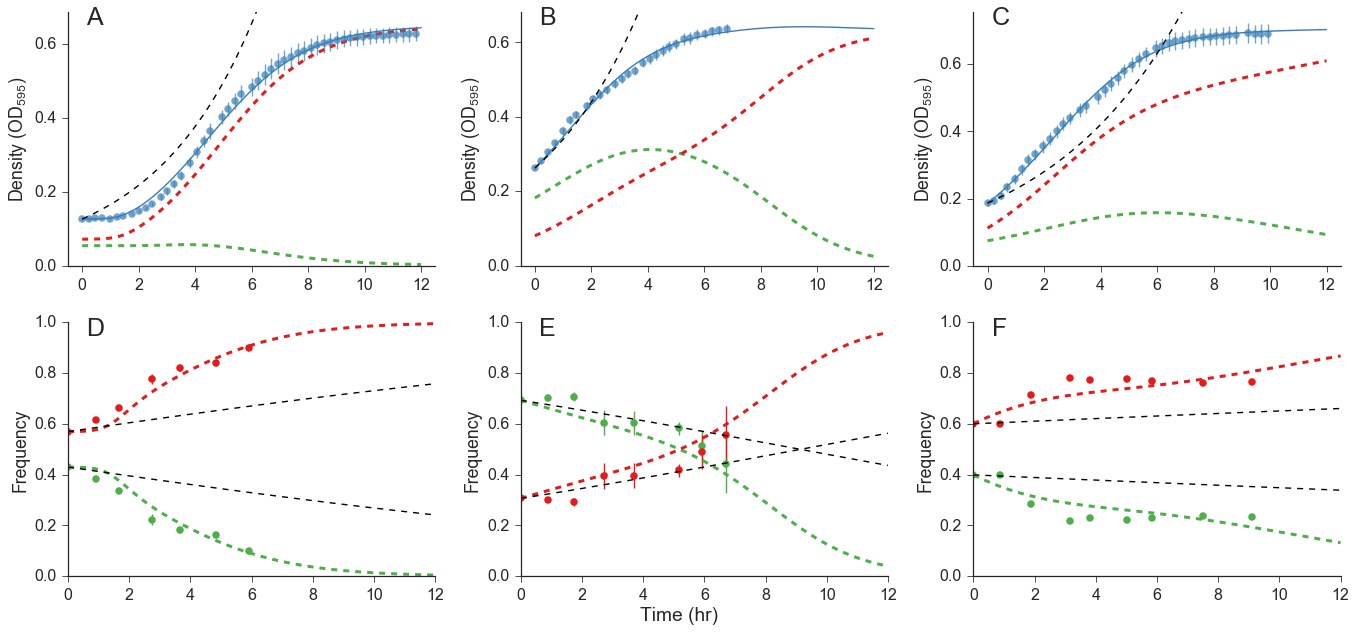

In [26]:
rows = 2
cols = len(datasets)
fig, ax = plt.subplots(rows, cols, sharex=False, sharey=False, figsize=(width * cols, height * rows))
ax.resize((rows, cols))
for col,(name, ds) in enumerate(datasets.items()):
    if col >= cols:
        break
   
    RG_model = ds['RG_model']
    RG_mean = ds['RG_mean']
    RG_std = ds['RG_std']
    RG_t = ds['RG_t']
    t = ds['predicted_t']
    y = ds['predicted_y']
    MRSE = ds['MRSE']
    
    ysum = y.sum(axis=1)
    p1 = y[:, 0] / ysum
    p2 = y[:, 1] / ysum
    
    ax[0, col].plot(t, y[:, 0], color=green, ls=pred_ls, lw=3)
    ax[0, col].plot(t, y[:, 1], color=red, ls=pred_ls, lw=3)
    ax[0, col].plot(t, ysum, color=blue, ls=fit_ls)
    ax[0, col].errorbar(RG_t, RG_mean, RG_std, fmt='o', color=blue, alpha=0.7)
    ax[0, col].plot(t, ds['Bexp'], color='k', ls=pred_ls) # exponential model

    ax[0, col].set(
        ylabel=r'Density ($OD_{595}$)', 
        xlim=(-0.5, t.max() + 0.5),
        ylim=(0, 1.1*RG_model.max()),
        title="",
        yticks=np.linspace(0, 0.6, 4)
    )

    ax[1, col].plot(t, p1, color=green, ls=pred_ls, lw=3)
    ax[1, col].plot(t, p2, color=red, ls=pred_ls, lw=3)
    idx = ds['flow_mean_df'].Strain == 'Green'
    g0 = ds['flow_mean_df'][idx].weight.max()
    ax[1, col].errorbar(
        ds['flow_mean_df'][idx].time, 
        ds['flow_mean_df'][idx].weight.as_matrix(), 
        ds['flow_std_df'][idx].weight.as_matrix(), 
        marker='o', 
        ls='', 
        color=green
    )
    idx = ds['flow_mean_df'].Strain == 'Red'
    r0 = ds['flow_mean_df'][idx].weight.min()
    ax[1, col].errorbar(
        ds['flow_mean_df'][idx].time, 
        ds['flow_mean_df'][idx].weight.as_matrix(), 
        ds['flow_std_df'][idx].weight.as_matrix(), 
        marker='o',
        ls='', 
        color=red
    )
    ax[1, col].plot(t, ds['pGexp'], color='k', ls=pred_ls) # exponential model
    ax[1, col].plot(t, ds['pRexp'], color='k', ls=pred_ls) # exponential model

    ax[1, col].set(
        ylabel='Frequency',        
        xlim=(0, t.max()),
        ylim=(0, 1),
        title="",
        yticks=np.linspace(0, 1.0, 6),
        
    )
    
    print(name, "MRSE: {:.2g}".format(MRSE), "a1={:.2g}, a2={:.2g}".format(*ds['a'])) 

fig_xlabel(fig, 'Time (hr)')
for i,axes in enumerate(ax.flatten()):
    axes.annotate('ABCDEFGH'[i], (0.05, 0.95), xycoords='axes fraction', fontsize=panel_label_size)
    
sns.despine()
fig.tight_layout()
fig.savefig('Fig-Competition_prediction.png')
fig.savefig('Fig-Competition_prediction.pdf', dpi=300)

Check that the prediction stabilizes.

# Colophon